<a href="https://colab.research.google.com/github/Qagent/Qagent/blob/main/dependency_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install dependencies

In [ ]:
!python --version

Python 3.7.13


In [ ]:
!nvcc -V && which nvcc

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
/usr/local/cuda/bin/nvcc


In [ ]:
# Check GPU
!nvidia-smi

Fri Jul 15 02:31:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [1]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.14.5
Uninstalling cffi-1.14.5:
  Successfully uninstalled cffi-1.14.5
Found existing installation: cryptography 3.4.5
Uninstalling cryptography-3.4.5:
  Successfully uninstalled cryptography-3.4.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec c

In [2]:
!python -m pip install "dask[complete]"
!pip install memory_profiler
!pip install fastparquet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31283 sha256=963d09b3e19f86b08221b99c7c4ce865fe0e6ae15d6e24639660294296da03a4
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.5 MB 14.5 MB/s 
     |████████████████████████████████| 1.6 MB 82.5 MB/s 


#Import Libraries


In [5]:
%matplotlib inline
import warnings
import glob
warnings.filterwarnings('ignore')
import sys
import os
from importlib import import_module
import numpy as np
import csv
from google.colab import drive
import torch as torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import pandas as pd 
import gc
import itertools as it
import collections
import re
import dask as dask
import dask.delayed as chainmap
import dask.dataframe as ditable
import dask.bag as diarray
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar
import io
import cupy
import json
from collections import Counter
from memory_profiler import memory_usage
import memory_profiler
import cudf
import cupy as cupy
import dask_cudf
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import dask_cudf
import numba
from numba import jit , njit

In [6]:
#%reload_ext memory_profiler

In [7]:
pbar = ProgressBar()
pbar.register()

#Create Schedulers

In [8]:
cluster = LocalCUDACluster() # by default use all GPUs in the node. 
client1 = Client(cluster)
client1

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 51.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45777,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 51.00 GiB
Comm: tcp://127.0.0.1:42981,Total threads: 1
Dashboard: http://127.0.0.1:41285/status,Memory: 51.00 GiB
Nanny: tcp://127.0.0.1:44169,


In [9]:
client2 = Client(processes = True)
client2

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36137/status,
Dashboard: http://127.0.0.1:36137/status,Workers: 4
Total threads: 8,Total memory: 51.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34215,Workers: 4
Dashboard: http://127.0.0.1:36137/status,Total threads: 8
Started: Just now,Total memory: 51.00 GiB
Comm: tcp://127.0.0.1:44081,Total threads: 2
Dashboard: http://127.0.0.1:34217/status,Memory: 12.75 GiB
Nanny: tcp://127.0.0.1:46683,


#Mount Db

In [10]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load data, clean text and save it to parquet files partitioned on language

##read_data_class

In [12]:
class read_data:
  
  def __init__(self,path):
    self.path = path
  
  def to_path(self):  
    x = self.path
    a = re.split('/',x)
    name = re.split('\.',a[-1])[0]
    d = a[:-2]
    d = [d for d in d if d != '']
    path = '/'+'/'.join(d)+'/'+ 'pre_processed_master' +'/'+name
    return path 
  def read_csv(self):
    path = self.path
    a = re.split('/',path)
    name = re.split('\.',a[-1])[0]
    data = ditable.read_csv(path,sep = 'rows',names = ['content'],header = None,dtype = str,assume_missing = True,engine='python' ,quotechar='"', on_bad_lines = 'skip', skip_blank_lines = True,quoting = csv.QUOTE_MINIMAL).sample(frac = 0.05) 
    data = data.dropna(how ='any')
    data['language'] = name
    def sanitary_check(x):
      x = x
      x = x.replace('<br>','.')
      x = x.replace('<b>',' ')
      x = x.replace('</b>',' ')
      x = x.replace('</u>',' ')
      x = x.replace('</i>',' ')
      x = x.replace('<u>',' ')
      x = x.replace('<i>',' ')
      x = x.replace('<i>',' ')
      x = re.sub(r'(\?){1,}',' ? ',x)
      x = re.sub(r'(\.){1,}',' . ',x) 
      x = re.sub(r'(\n){1,}','\n',x)
      x = re.sub(r'(\|)+','|',x)
      x = re.sub(r'(\!){1,}','!',x)
      x = re.sub(r'([\xa0])+',' ',x)
      new = re.sub(r'(,)+',' , ',x) 
      new = re.sub(r'(\s)+',' ',new)
      new = re.sub(r'(^\s)+','',new)
      x = re.sub(r'(\s)+'," ",x)
      x = re.sub(r'(\|)'," | ",x)
      x = re.sub(r'(-)+'," - ",x)
      x = re.sub(r'(\"){1,}','',x)
      x = re.sub(r'(\[unkc\])+',"[unkc]",x)
      return new
    data.content = data.content.apply(sanitary_check,meta=pd.Series(dtype = str))
    def len_fil(x):
      x = str(x)
      if x == None:
        return '<NA>'
      elif len(x)>75:
        return x
      else:
        return '<NA>'

    data.content = data.content.apply(len_fil)
    data = data[(data.content != '<br>') & (data.content != '<NA>') & (data.content != None)]  
    data = data.map_partitions(cudf.DataFrame.from_pandas)
    data['content'] = data.content.astype(str)
    to_path = read_data(path).to_path()
    to_path_content = to_path+'/'+'content_temp'
    data.to_parquet(to_path_content,write_index = False, compute = False).compute(scheduler = 'distributed')
    return to_path_content

##load_data

In [14]:
class load_data(read_data):
  
  def __init__(self,path):
    self.path = path
  
  def to_path(self):  
    x = self.path
    a = re.split('/',x)
    name = re.split('\.',a[-1])[0]
    d = a[:-2]
    d = [d for d in d if d != '']
    path = '/'+'/'.join(d)+'/'+ 'pre_processed_master' +'/'+name
    return path 
  def read_csv(self):
    path = self.path
    a = re.split('/',path)
    name = re.split('\.',a[-1])[0]
    data = ditable.read_csv(path,sep = 'rows',names = ['content'],header = None,dtype = str,assume_missing = True,engine='python' ,quotechar='"', on_bad_lines = 'skip', skip_blank_lines = True,quoting = csv.QUOTE_MINIMAL) 
    data = data.dropna(how ='any')
    def sanitary_check(x):
      x = x
      x = x.replace('<br>','.')
      x = x.replace('<b>',' ')
      x = x.replace('</b>',' ')
      x = x.replace('</u>',' ')
      x = x.replace('</i>',' ')
      x = x.replace('<u>',' ')
      x = x.replace('<i>',' ')
      x = x.replace('<i>',' ')
      x = re.sub(r'(\?){1,}',' ? ',x)
      x = re.sub(r'(\.){1,}',' . ',x) 
      x = re.sub(r'(\n){1,}','\n',x)
      x = re.sub(r'(\|)+','|',x)
      x = re.sub(r'(\!){1,}','!',x)
      x = re.sub(r'([\xa0])+',' ',x)
      new = re.sub(r'(,)+',' , ',x) 
      new = re.sub(r'(\s)+',' ',new)
      new = re.sub(r'(^\s)+','',new)
      x = re.sub(r'(\s)+'," ",x)
      x = re.sub(r'(\|)'," | ",x)
      x = re.sub(r'(-)+'," - ",x)
      x = re.sub(r'(\"){1,}','',x)
      return new
    data.content = data.content.apply(sanitary_check,meta=pd.Series(dtype = str))
    def len_fil(x):
      x = str(x)
      if x == None:
        return '<NA>'
      elif len(x)>75:
        return x
      else:
        return '<NA>'

    data.content = data.content.apply(len_fil)
    data = data[(data.content != '<br>') & (data.content != '<NA>') & (data.content != None)]  
    data = data.map_partitions(cudf.DataFrame.from_pandas)
    data['content'] = data.content.astype(str)
    to_path = read_data(path).to_path()
    to_path_content = to_path+'/'+'content'
    data.to_parquet(to_path_content,write_index = False, compute = False).compute(scheduler = 'distributed')
    return to_path_content


    
    

##build bogs

In [21]:
class bow(read_data):
  def __init__(self, path):
      super().__init__(path)
      path = self.path  

  def bow_run(self):
    path = self.path
    a = re.split('/',path)
    name = re.split('\.',a[-1])[0]
    data_path = read_data(path).to_path() +'/'+'clean_content'
    data = ditable.read_parquet(data_path)
    to_path = read_data(path).to_path()
    to_path = to_path+'/'+'bow'

    def bow_create(a1):
      a = a1
      b = re.split('[\b\W\b\s]+\s*',a)
      b = [b.lower().strip() for b in b if b != ''and b != ' 'and b != ' "" '] 
      data = b
      return data
    def doc_set(b1):
      b = b1
      b = [b.lower().strip() for b in b if b != ''and b != ' 'and b != ' "" '] 
      b = list(set(b))
      return b
    bow = data.clean_content.apply(bow_create,meta = pd.Series(dtype = str))
    bow = bow.to_frame('bow')
    bow['doc_set'] = bow.bow.apply(doc_set,meta = pd.Series(dtype = str) )
    bow = bow.rename(columns = {'bow':'bag_of_words'})
    bow['language'] = name
    bow = bow.map_partitions(cudf.from_pandas)
    bow.to_parquet(to_path,write_index = False, compute = False).compute(scheduler = 'distributed')
    return to_path

##word_vocabulary



In [22]:
class build_vocab(read_data):
  def __init__(self,path):                      
    super().__init__(path)
    self.path = path


  def vocab(self):
    path = self.path
    data_path = bow(path).bow_run()
    data = dask_cudf.read_parquet(data_path , write_index = False,columns = 'bag_of_words').explode(column = 'bag_of_words')
    data = data.groupby('bag_of_words').bag_of_words.count()
    data = data.to_frame('freq')
    data = data.reset_index()
    data = data.rename(columns ={'bag_of_words':'word','freq':'word_freq'})
    return data

  def doc_freq(self):
    path = self.path
    data_path = bow(path).bow_run()
    data = dask_cudf.read_parquet(data_path , write_index = False,columns = 'doc_set').explode(column = 'doc_set')
    data = data.groupby('doc_set').doc_set.count()
    data = data.to_frame('freq')
    data = data.reset_index()
    data = data.rename(columns ={'doc_set':'word','freq':'doc_freq'})
    return data 

  def master_run(self):
    path = self.path
    a = re.split('/',path)
    name = re.split('\.',a[-1])[0]
    data_words = self.vocab()
    data_docs = self.doc_freq()
    data = data_words.merge(data_docs,on =['word'],how = 'inner')
    data['len'] = data.word.str.len()
    data = data.compute(scheduler = 'distributed')
    filter = data.len.mode().to_arrow().to_pylist()
    filter = filter[0]
    keys = data[(data.word_freq == 1)&(data.doc_freq ==1)&(data.len == filter)]
    to_path = read_data(path).to_path()
    to_path_vocab = to_path+'/'+'vocabulary'
    to_path_keys = to_path+'/'+'keys'
    data = dask.dataframe.from_pandas(data, npartitions=1)
    keys = dask.dataframe.from_pandas(keys, npartitions=1)
    keys['language'] = name
    data['language'] = name
    data.to_parquet(to_path_vocab,write_index = False, compute = False).compute(scheduler = 'distributed')
    keys.to_parquet(to_path_keys,write_index = False, compute = False).compute(scheduler = 'distributed')

##build_char_vocab

In [17]:
class build_char(read_data):
  def __init__(self,path):                      
    super().__init__(path)
    self.path = path


  def char(self):
    path = self.path
    data_path = read_data(path).read_csv()
    data = dask_cudf.read_parquet(data_path , write_index = False,columns = 'content').explode(column = 'content')
    data['content'] = data.content.str.lower()
    data['char'] = data.content.str.character_tokenize()
    char_freq = data.groupby('char').char.count()
    char_table = char_freq.to_frame('freq')
    char_table['prob'] = char_table.freq / char_table.freq.sum()
    char_table = char_table.compute(scheduler = 'distributed')
    char_table = char_table.reset_index(drop = False)
    char_table = char_table.rename(columns ={'char':'char','freq':'char_freq','prob':'prob'})
    char_table = char_table.sort_values('prob',ascending = True)
    return char_table

  
  def char_policy(self):
    data = self.char()
    for i in range(10):
      data1 = self.char()
      data = data.merge(data1,on = ['char'],how = 'outer',suffixes = ('_a','_b'))
      data = data.fillna(0)
      data['increment'] = data.prob_a - data.prob_b
      data['increment'] = data.increment.multiply(0.05)
      data['prob'] = data.prob_a + data.increment
      data['char_freq'] = data.char_freq_a + data.char_freq_b
      data = data.drop(columns = ['char_freq_a','char_freq_b','prob_a','prob_b','increment'])
    return data

  def char_run(self):
    path = self.path
    data = self.char_policy()
    a = re.split('/',path)
    name = re.split('\.',a[-1])[0]
    data = data[(data.prob > 0) & (data.char_freq > 10)]
    data = data.sort_values(by = 'prob' ,ascending = False)
    data['language'] = name
    to_path = self.to_path()+'/'+'char_dict/'
    data = dask_cudf.from_cudf(data,npartitions = 1)
    data.to_parquet(to_path,write_index = False,compute = False).compute(scheduler = 'distributed')
    return to_path

##build_word_dictionay


In [26]:
class build_word_dictionary(read_data):
  def __init__(self,path):                      
    super().__init__(path)
    self.path = path


  def char(self):
    path = self.path
    data_path = read_data(path).to_path()+'/bow'
    data = dask_cudf.read_parquet(data_path , write_index = False,columns = 'bag_of_words').explode(column = 'bag_of_words').sample(frac = 0.09)
    char_freq = data.groupby('bag_of_words').bag_of_words.count()
    char_table = char_freq.to_frame('freq')
    char_table['prob'] = char_table.freq / char_table.freq.sum()
    char_table = char_table.compute(scheduler = 'distributed')
    char_table = char_table.reset_index(drop = False)
    char_table = char_table.rename(columns ={'bag_of_words':'word','freq':'word_freq','prob':'prob'})
    char_table = char_table.sort_values('prob',ascending = True)
    return char_table

  
  def char_policy(self):
    data = self.char()
    for i in range(10):
      data1 = self.char()
      data = data.merge(data1,on = ['word'],how = 'outer',suffixes = ('_a','_b'))
      data = data.fillna(0)
      data['increment'] = data.prob_a - data.prob_b
      data['increment'] = data.increment.multiply(0.05)
      data['prob'] = data.prob_a + data.increment
      data['word_freq'] = data.word_freq_a + data.word_freq_b
      data = data.drop(columns = ['word_freq_a','word_freq_b','prob_a','prob_b','increment'])
    return data

  def word_run(self):
    path = self.path
    data = self.char_policy()
    a = re.split('/',path)
    name = re.split('\.',a[-1])[0]
    data = data[(data.prob > 0) & (data.word_freq > 20)]
    data = data.sort_values(by = 'prob' ,ascending = False)
    data['language'] = name
    to_path = self.to_path()+'/'+'word_dict/'
    data = dask_cudf.from_cudf(data,npartitions = 1)
    data.to_parquet(to_path,write_index = False,compute = False).compute(scheduler = 'distributed')
    return to_path

##pre_process

In [19]:
class parse(read_data):
  def __init__(self,path):                      
    super().__init__(path)
    self.path = path
  def parser(self):
    path = self.path
    data_path = load_data(path).read_csv()
    data = ditable.read_parquet(data_path,index = None,columns = ['content'])
    #data = data.reset_index(drop = True)
    dicti_path = build_char(path).char_run()
    dicti = ditable.read_parquet(dicti_path,column = ['char']) 
    dicti = dicti.compute(scheduler = 'threads')  
    dicti = dicti.char.to_dict() 

    def check_char(str_data):    
      str_data = str_data
      chk =[str_data[i].lower() for i in range(len(str_data))]
      def filt(da):
        if da in dicti.values():
          return da
        else: 
          return '[unkc]'
      new_a = list(map(filt,chk))
      num_unk = len([x for x in new_a if x == '[unkc]'])
      num_chars = len(new_a)
      if num_chars < 75 and num_unk/num_chars > 0.2:
        new_a = ['missing']
      else:
        new_a = new_a

      new_a = "".join(new_a)
      return new_a
    
    def sanitary_check(stri):
      stri = re.sub(r'(\[unkc\])+',"[unkc]",stri)
      stri = re.sub(r'(^\s)+','',stri)
      stri = re.sub(r'(\s){1,}',' ',stri)
      return stri

    data['clean_content'] = data.content.apply(check_char,meta = pd.Series(dtype = str))
    data['clean_content'] = data.clean_content.apply(sanitary_check , meta = pd.Series(dtype = str))
    data = data[(data.clean_content != ' ') & (data.clean_content != None)&(data.clean_content != 'missing')&(data.clean_content != '[unkc]')]
    data = data.drop(columns = ['content'])
    to_path = read_data(path).to_path()
    to_path_content = to_path+'/'+'clean_content'
    data = data.map_partitions(cudf.DataFrame.from_pandas)
    data.to_parquet(to_path_content,write_index = False,compute = False).compute(scheduler = 'distributed')
    return to_path_content

#Run for all languages

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prenglish.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prenglish.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prenglish.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prodia.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prodia.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prodia.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prurdu.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prurdu.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prurdu.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prpunjabi.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prpunjabi.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prpunjabi.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prtamil.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prtamil.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prtamil.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prmarathi.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prmarathi.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prmarathi.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prbengali.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prbengali.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prbengali.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prhindi.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prhindi.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prhindi.csv').word_run()

In [ ]:
%time eng = parse('/content/drive/My Drive/DataNew/prmalyali.csv').parser()
%time eng = build_vocab('/content/drive/My Drive/DataNew/prmalyali.csv').master_run()
%time eng = build_word_dictionary('/content/drive/My Drive/DataNew/prmalyali.csv').word_run()

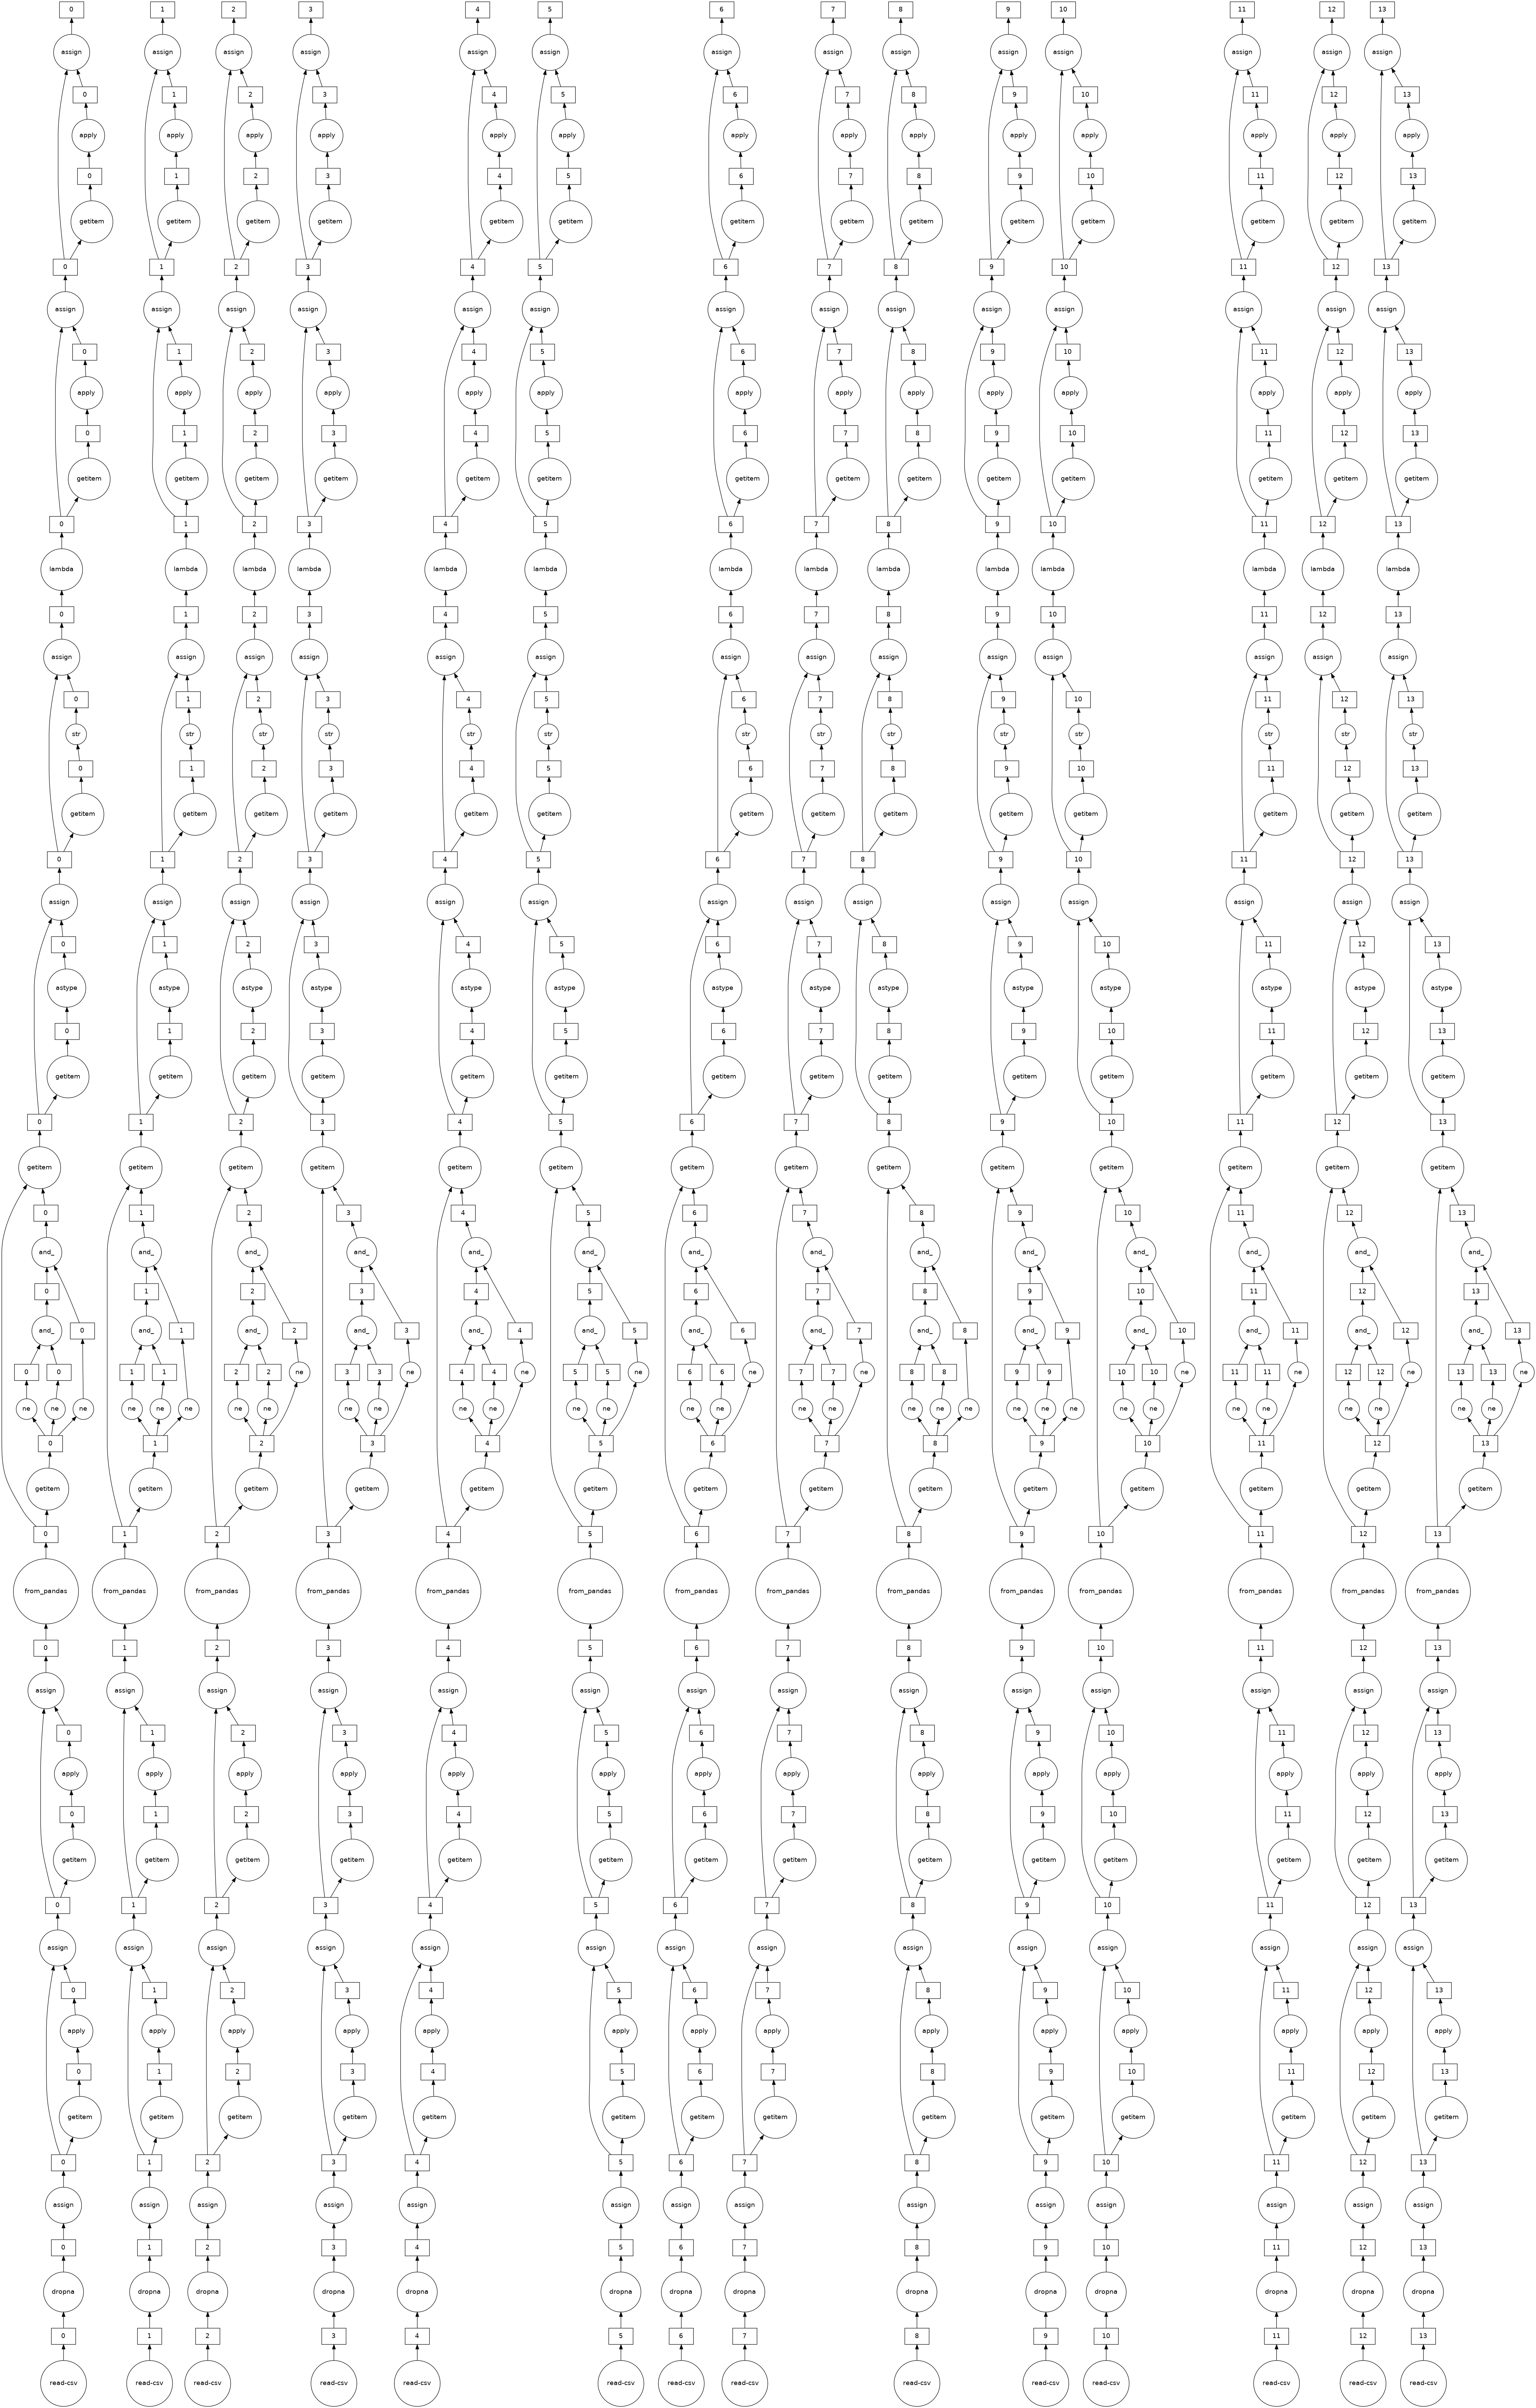

In [ ]:
eng.visualize()

##run_executions

In [ ]:
%time eng = build_vocab('/content/drive/My Drive/DataNew/prenglish.csv').vocab_run()

CPU times: user 4.75 s, sys: 1.59 s, total: 6.34 s
Wall time: 23.1 s


In [ ]:
%time eng = build_vocab('/content/drive/My Drive/DataNew/prenglish.csv').vocab_run()
%time od = build_vocab('/content/drive/My Drive/DataNew/prodia.csv').vocab_run()
%time ur = build_vocab('/content/drive/My Drive/DataNew/prurdu.csv').vocab_run()
%time pu = build_vocab('/content/drive/My Drive/DataNew/prpunjabi.csv').vocab_run()
%time be = build_vocab('/content/drive/My Drive/DataNew/prbengali.csv').vocab_run()
%time ta = build_vocab('/content/drive/My Drive/DataNew/prtamil.csv').vocab_run()
%time mar = build_vocab('/content/drive/My Drive/DataNew/prmarathi.csv').vocab_run()
%time hi = build_vocab('/content/drive/My Drive/DataNew/prhindi.csv').vocab_run()
%time mal = build_vocab('/content/drive/My Drive/DataNew/prmalyali.csv').vocab_run()

CPU times: user 15.4 s, sys: 4.69 s, total: 20.1 s
Wall time: 3min 20s
CPU times: user 16.4 s, sys: 5.49 s, total: 21.9 s
Wall time: 3min 37s
CPU times: user 7.18 s, sys: 2.52 s, total: 9.7 s
Wall time: 1min 34s
CPU times: user 10.1 s, sys: 2.99 s, total: 13.1 s
Wall time: 2min 18s
CPU times: user 2min 2s, sys: 37.4 s, total: 2min 40s
Wall time: 27min 43s
CPU times: user 1min 43s, sys: 23.9 s, total: 2min 7s
Wall time: 23min 23s
CPU times: user 1min 37s, sys: 29.4 s, total: 2min 7s
Wall time: 21min 21s
CPU times: user 2min 43s, sys: 39.5 s, total: 3min 22s
Wall time: 38min 20s


In [ ]:
data_vocab = dask_cudf.read_parquet('/content/drive/My Drive/pre_processed_data_final/prbengali/vocabulary').compute(scheduler = 'distributed')

In [ ]:
data_keys = dask_cudf.read_parquet('/content/drive/My Drive/pre_processed_data_final/prbengali/keys').compute(scheduler = 'distributed')

In [ ]:
data_frac = data_keys.size/data_vocab.size

In [ ]:
data_frac

0.13141087928201686

In [ ]:
data = os.walk('/content/drive/My Drive/pre_processed_data_final/')

In [ ]:
a = list(data)

In [ ]:
paths = [a[0][0]+a[0][1][i]+'/'+'keys/part.0.parquet' for i in range(len(a[0][1]))]

In [ ]:
paths

['/content/drive/My Drive/pre_processed_data_final/prenglish/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prodia/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prurdu/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prpunjabi/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prbengali/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prtamil/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prmarathi/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prhindi/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prmalyali/keys/part.0.parquet']

In [ ]:
list_files = glob.glob('/content/drive/My Drive/pre_processed_data_final/pr*/keys/*parquet')

In [ ]:
list_files

['/content/drive/My Drive/pre_processed_data_final/prenglish/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prodia/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prurdu/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prpunjabi/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prbengali/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prtamil/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prmarathi/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prhindi/keys/part.0.parquet',
 '/content/drive/My Drive/pre_processed_data_final/prmalyali/keys/part.0.parquet']

In [ ]:
data = dask_cudf.read_parquet(list_files)